# CBLOF for outliers detection

This notebook attempts to use CBLOF (Cluster based Local Outlier Factor) for outlier detection and automate auto-tuning of the parameters. 

It works similar to LOF but it defines anomalies as a combination of local distances to nearby clusters and the size of the clusters to which the data point belongs. Therefore, the local outliers may not be a singular point but a small group of isolated points. See [LOF NB](LOF.ipynb) beforehand recommended since this NB may skip details similar to it 

Table of contents:
1. [](#)
2. 

Reference:

1. Handbook of Anomaly Detection: With Python Outlier Detection — (10) Cluster-Based-Local Outlier: [LINK](https://medium.com/@gabrielpierobon/k-nearest-neighbors-knn-for-anomaly-detection-d9bcc2d4f71a)
    - Github NB: [LINK](https://github.com/dataman-git/codes_for_articles/blob/master/10.%20CBLOF.ipynb)
    

This uses the cblof function from PyOD, be sure to install them before running this NB: [LINK](https://pyod.readthedocs.io/en/latest/_modules/pyod/models/cblof.html):

In [66]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
from pyod.models.cblof import CBLOF
import pyleoclim as pyleo

## Synthetic dataset
We first start with a synthetic dataset to understand the basics of CBLOF anomaly detection. 

The purple points are inliers and yellow points are outliers.

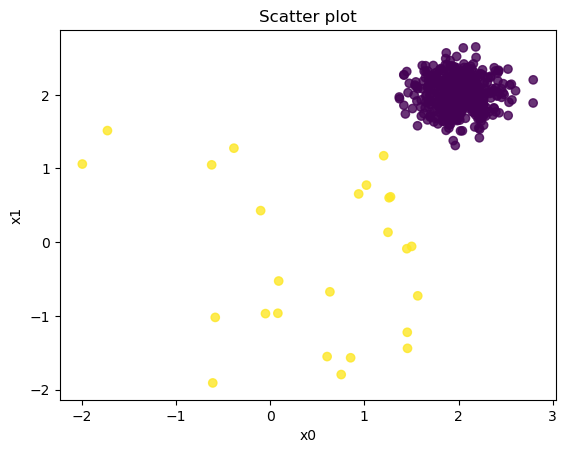

In [2]:
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

### Build the model
There're several parameters we could tune for CBLOF:
1. n_clusters: the number of clusters to form as well as the number of centroids to generate
2. contamination: the percentage of outliers, in most cases, we don't know the contamination of outliers so we can assign a value based on any prior knowledge
3. alpha: count percentage of the large clusters
4. beta: coefficient to decide small and large clusters. Sort all cluster by its size, if cluster A is beta times larger than cluster B, cluster A and above are considered large clusters and others are considered small clusters
5. use_weights

Here, we only set n_clusters to 10 and contamination to 0.05 (which is same as the data we generated previously)

In [3]:
cblof = CBLOF(n_clusters=10, contamination = 0.05) 
cblof.fit(X_train)

# Training data
y_train_scores = cblof.decision_function(X_train) # generates outlier/anomaly score
y_train_pred = cblof.predict(X_train) # assign '0', '1' by comparing an outlier score to the threshold, above threshold -> 1, otherwise 0

# Test data
y_test_scores = cblof.decision_function(X_test)
y_test_pred = cblof.predict(X_test)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , cblof.threshold_)

The training data: {0: 475, 1: 25}
The training data: {0: 475, 1: 25}
The threshold for the defined comtanimation rate: 1.0450453945033702


In [4]:
cblof.get_params()

{'alpha': 0.9,
 'beta': 5,
 'check_estimator': False,
 'clustering_estimator': None,
 'contamination': 0.05,
 'n_clusters': 10,
 'n_jobs': None,
 'random_state': None,
 'use_weights': False}

### Determine the threshold
Threshold is a value based on contamination, and any point with anomaly score > threshold is considered outlier. There're two ways to determine a threshold value:
1. Built-in function 'threshold_'
2. Histogram: Plot out all scores and choose based on business/real situation or domain knowledge

Here, we give an example to show how to plot out a histogram

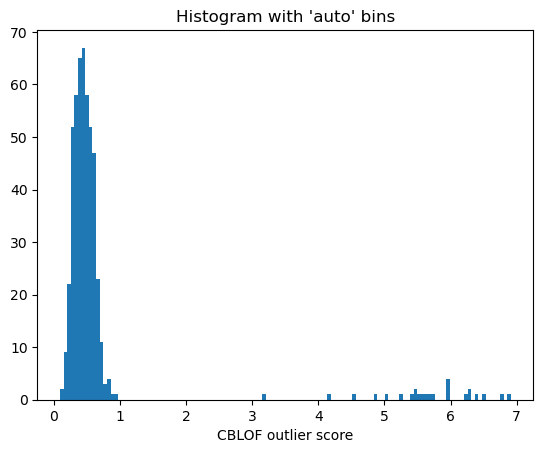

In [5]:
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('CBLOF outlier score')
plt.show()

### Descriptive statistics
Here, we list out several statistics based on different groups:
1. Count
2. Count %
3. Feature mean
4. Anomaly Score: Used to verify the anomaly score is higher in the outlier group than the normal group, don't need to interpret too much on the scores

In [6]:
threshold = cblof.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'}) # average of anomaly score
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # Means of the feature in different groups
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,0.45
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,5.63


Because this case we have the ground truth in our data generation, here we could produce a confusion matrix to understand the model performance. 

And looks like it delivers a decent job and identifys all 25 outliers

In [7]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores})
Actual_pred['Pred'] = np.where(Actual_pred['Anomaly_Score']< threshold,0,1)
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


### Achieve model stability by aggregating multiple models
To reduce overfitting for the models, we often train models with a range of hyperparameters and aggregate the outlier scores.

Here, we produce 5 CBLOF models with 10, 20, 30, 40, and 50 n_clusters. The average outlier scores of these models will be the final model prediction

Also, we leverage the combo package here, so be sure the combo package is installed beforehand

In [8]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of neighbors from 10 to 50. There will be 5 models.
n_clf = 5
k_list = [10, 20, 30, 40, 50]

# Prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    cblof = CBLOF(n_clusters = k, contamination=0.05)  
    cblof.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = cblof.decision_function(X_train_norm) 
    test_scores[:, i] = cblof.decision_function(X_test_norm)
    
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

The y_by_average is the average prediction of the 5 model predictions for the training data, which are stored in the dataframe train_scores-norm.

From the histogram, it shows that most of the scores are below 0.2

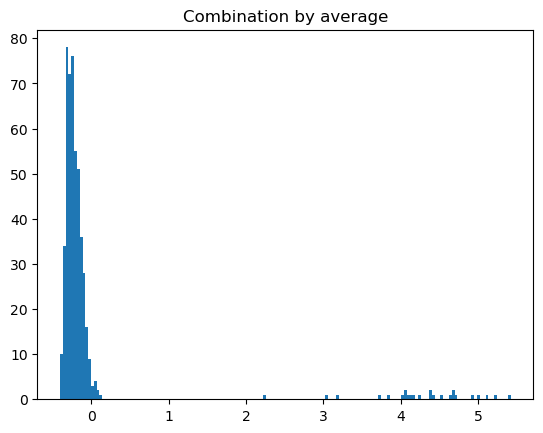

In [9]:
# Combination by average
# The test_scores_norm is 500 x 5. The "average" function will take the average of the 5 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)

plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [10]:
descriptive_stat_threshold(X_train,y_train_by_average, 1) # here, we set the threshold = 1

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.23
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,4.28


In [11]:
descriptive_stat_threshold(X_test,y_test_by_average, 1)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.02,2.01,2.01,1.99,2.01,2.00,-0.20
1,Outlier,25,5.0,0.00,-0.54,-0.23,-0.05,-0.06,0.12,4.33


In [12]:
# Import necessary libraries
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

The dataset contains only numerical input variables which are the result of a PCA transformation.

Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.
- Time: contains the seconds elapsed between each transaction and the first transaction in the dataset
- Amount: The transaction amount
- Class: response variable and it takes value 1 in case of fraud and 0 otherwise

In [13]:
# Load the dataset
data = pd.read_csv('creditcard.csv')

# Take a look at the data
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


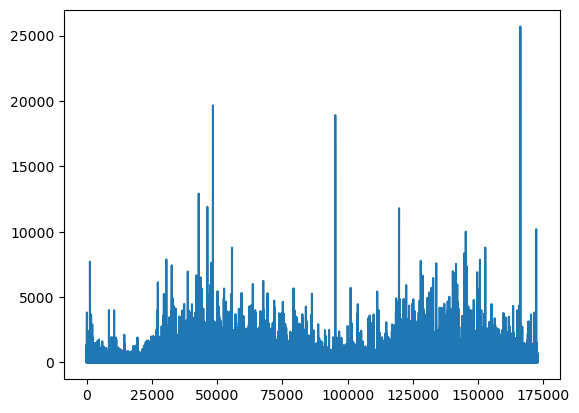

In [14]:
plt.plot(data['Time'],data['Amount'])

### Exploration of the dataset

In [15]:
print(data['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


### Sample dataset

In [16]:
# Set the fraction of data to sample
fraction = 0.1

# We will use stratified sampling to maintain the ratio of anomalies
stratified_data = data.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=fraction))

# Separate out the features and labels
X_sample = stratified_data.drop('Class', axis=1)
y_sample = stratified_data['Class']

# Standardize the features to have a mean of ~ 0 and a variance of 1
scaler = StandardScaler()
X_std_sample = scaler.fit_transform(X_sample)

In [17]:
X_std_sample

array([[ 1.63392955,  0.86254576, -0.30661721, ...,  0.23118632,
        -0.12246726, -0.05400088],
       [ 1.19059409,  1.02185544, -0.10549018, ..., -0.19630231,
        -0.2267109 , -0.38080196],
       [-0.36852474,  0.67143833,  0.26386392, ..., -0.03130283,
         0.08057732, -0.38260475],
       ...,
       [ 0.12809268, -3.51369223,  3.15885658, ...,  0.75832869,
         5.67857237, -0.38319066],
       [ 0.9589123 , -1.46564104, -0.15128415, ...,  1.83094561,
         0.74816436,  2.8728766 ],
       [ 0.05690966, -9.05352429,  7.90571246, ..., -8.18335954,
        -1.72039771, -0.34767566]])

### Train model
Finally, after sampling the dataset, we start to train our KNN models. Here, we adopted two kinds of anomalty detection: novelty and outlier.

Novelty trains on only the normal trascations and looks for the "strange" data points and mark it as outlier, while the default outlier trains on the whole transaction and looks for data points that have a substantially lower density than their neighbors

#### Novelty

In [18]:
# Train the model
# Note that this is novelty detection so we only train on normal transactions
model = LocalOutlierFactor(n_neighbors=20, novelty=True)
model.fit(X_std_sample[y_sample == 0])  # train the model on the normal transactions

# Predict the labels for the entire dataset
y_pred = model.predict(X_std_sample)

# Convert the prediction values to match with 'Class' column in the original dataset
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

# Print the confusion matrix
print(confusion_matrix(y_sample, y_pred))

[[26977  1455]
 [    6    43]]


In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_sample, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     28432
           1       0.03      0.88      0.06        49

    accuracy                           0.95     28481
   macro avg       0.51      0.91      0.51     28481
weighted avg       1.00      0.95      0.97     28481



#### Outlier

In [20]:
# Train the model and predict the labels for the entire dataset
model = LocalOutlierFactor(n_neighbors=20, novelty=False)
y_pred = model.fit_predict(X_std_sample)

# Convert the prediction values to match with 'Class' column in the original dataset
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

# Print the confusion matrix
print(confusion_matrix(y_sample, y_pred))

[[26728  1704]
 [   36    13]]


In [21]:
print(classification_report(y_sample, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     28432
           1       0.01      0.27      0.01        49

    accuracy                           0.94     28481
   macro avg       0.50      0.60      0.49     28481
weighted avg       1.00      0.94      0.97     28481



From the results, we could observe that novelty did a better job than outlier, scoring a higher score on recall (which we care more in this case) while outlier only scores lower

Let's try to only use the amount data since this would be closer to what we need to do for paleoclimate timeseries.

In [ ]:
X = np.array(data['Amount']).reshape(-1, 1)

model = LocalOutlierFactor(n_neighbors=20, novelty=False)
y_pred = clf.fit_predict(X)

In [ ]:
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(data['Time'], X, color=colors[(y_pred + 1) // 2])
plt.title("Local Outlier Factor (LOF)")
plt.show()

## (WIP) Explore CBLOF parameters
Before we get into timeseries data, let's try out how parameters affect the outcome of anomalty detection of CBLOF

#### Generate nicely defined clusters

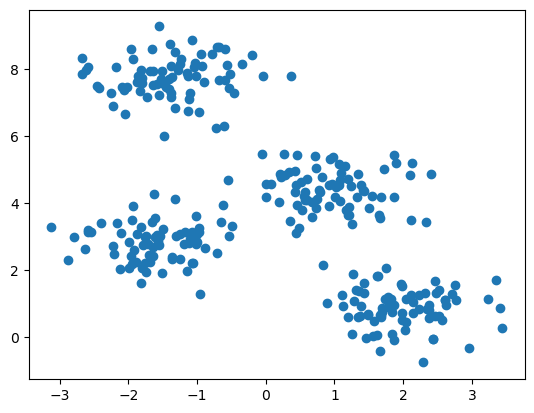

In [22]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

#### Prepare data

In [23]:
from sklearn.preprocessing import StandardScaler

# Standardize the features to have a mean of ~ 0 and a variance of 1
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### Compare - n_clusters & contamination

#### Train Model

In [50]:
# list of parameters being tested
cluster_list = np.arange(2,11,2)
contam_list = np.arange(0.05, 0.35, 0.05)

In [51]:
# Train the model and record the results, labels_: 0 -> inliers and 1 -> outliers/anomalies
predictions = []
for c in cluster_list:
    for contam in contam_list:
        try:
            model = CBLOF(n_clusters=c, contamination=contam)
            model.fit(X_std)
            predictions.append([c, contam, model.labels_])
        except:
            pass

#### Plot results

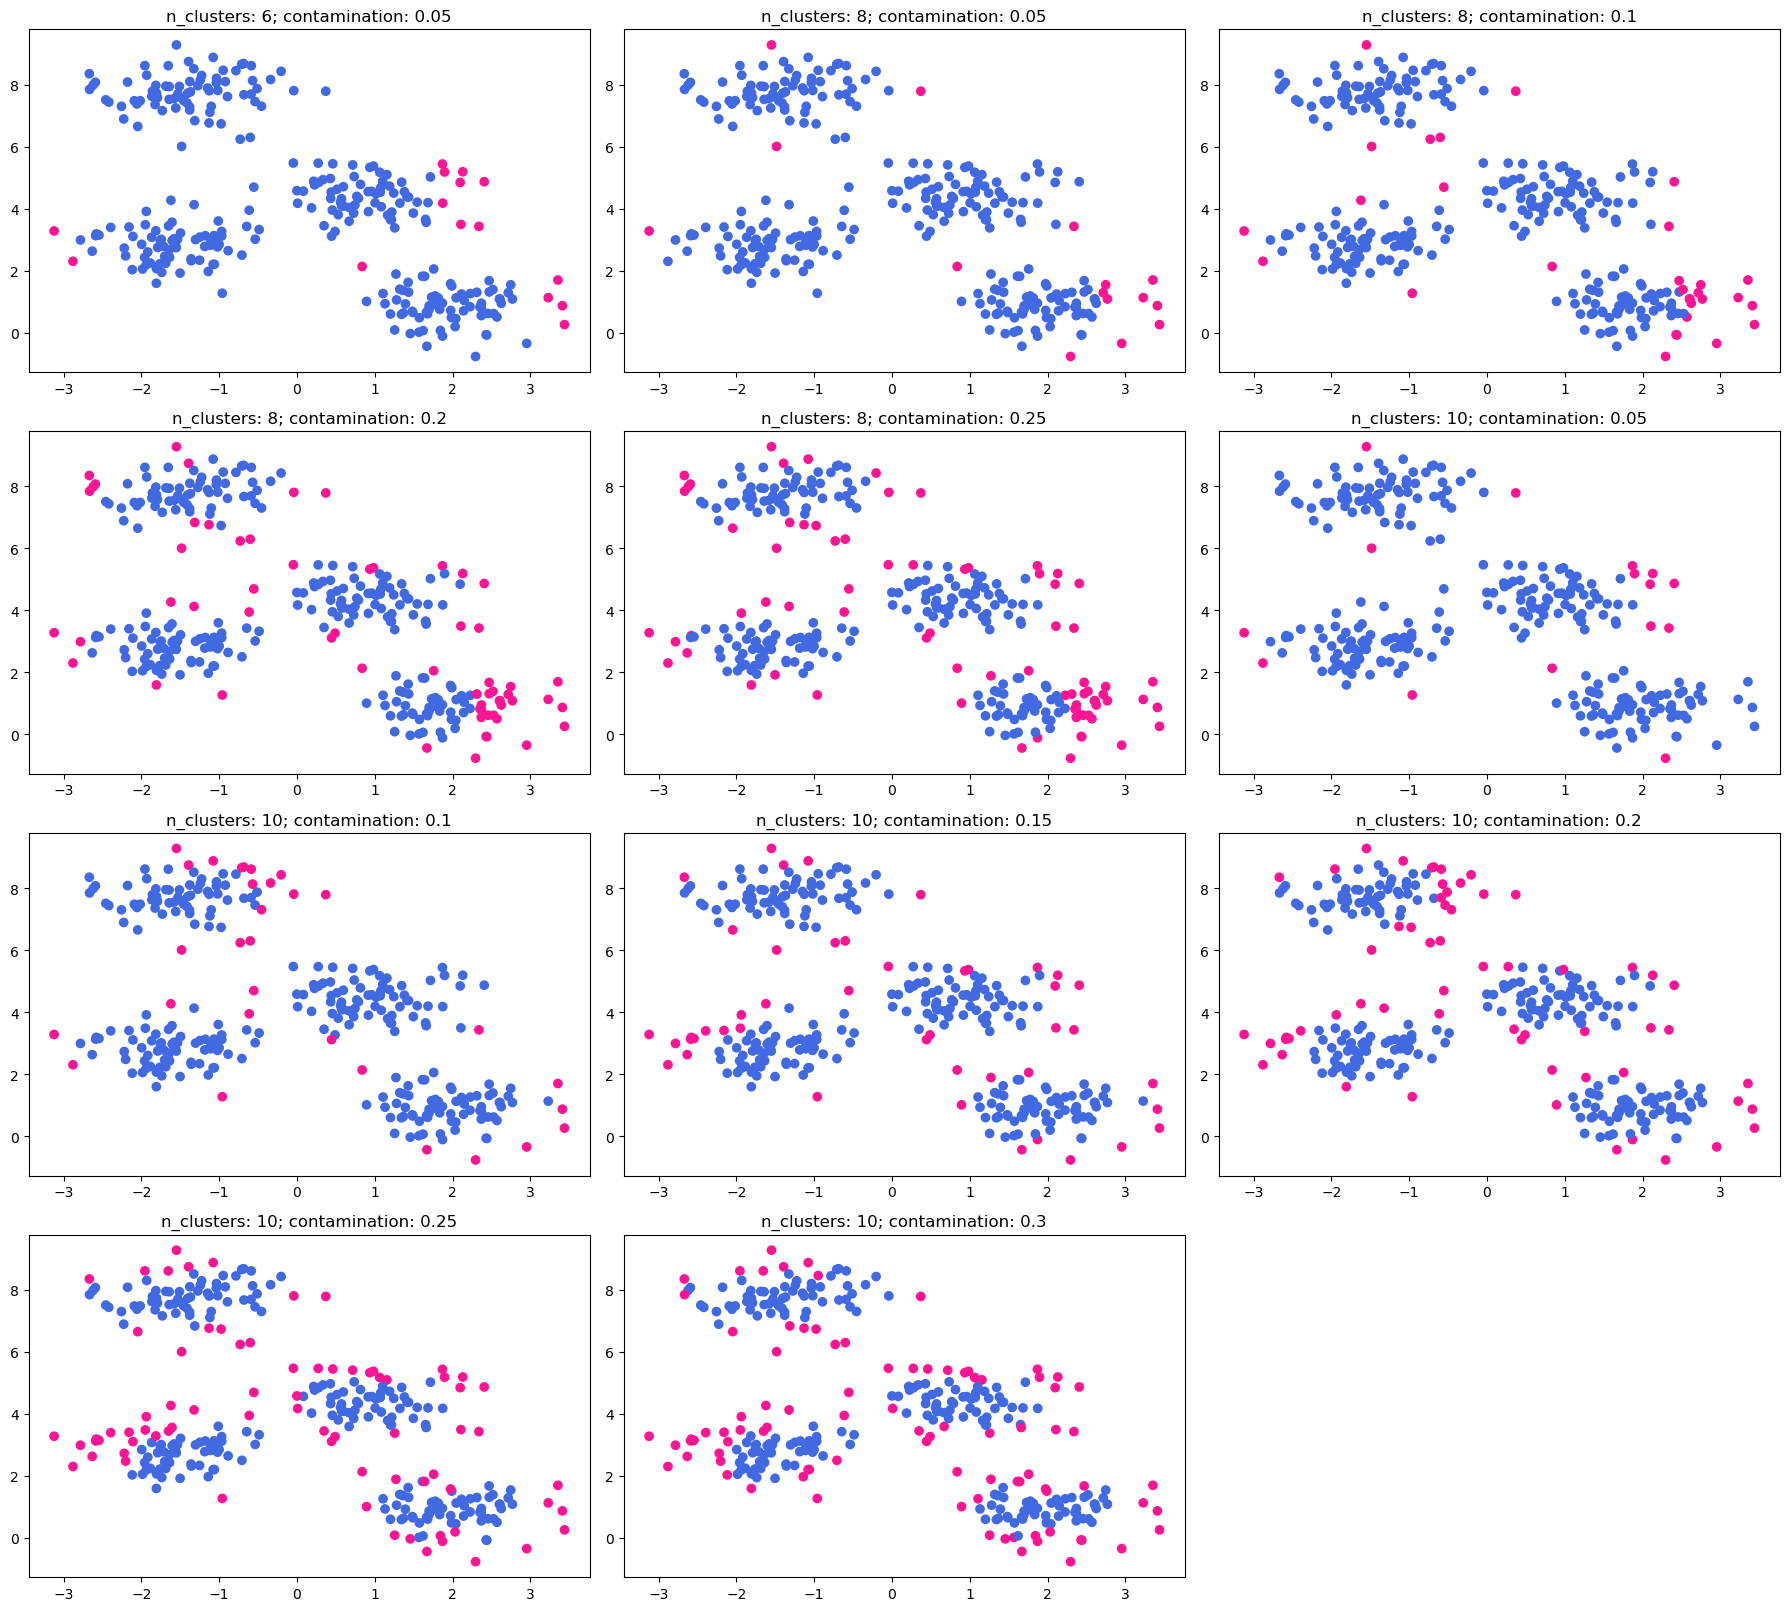

In [57]:
# colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
colors = ['royalblue', 'deeppink']
fig, axes = plt.subplots(5, 3, figsize=(18, 20))
for i, y_pred in enumerate(predictions):
    row, col = divmod(i, 3)
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    ax = axes[row, col]
    
    # ax.scatter(X[:, 0], X[:, 1], c=vectorizer(y_pred[2]))
    ax.scatter(X[:, 0], X[:, 1], c=vectorizer((y_pred[2] + 1) // 2))
    ax.set_title('n_clusters: ' + str(y_pred[0]) + '; contamination: ' + str(y_pred[1])[:4])

# hide extra plots
for i in range(len(predictions), 5 * 3):
    row, col = divmod(i, 3)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

Wow that's a lot of plots, let's pick out some of them and compare how n_clusters and contamination affect the results.

Let's pick out these first: (6, 0.05), (8, 0.05), (10, 0.05)

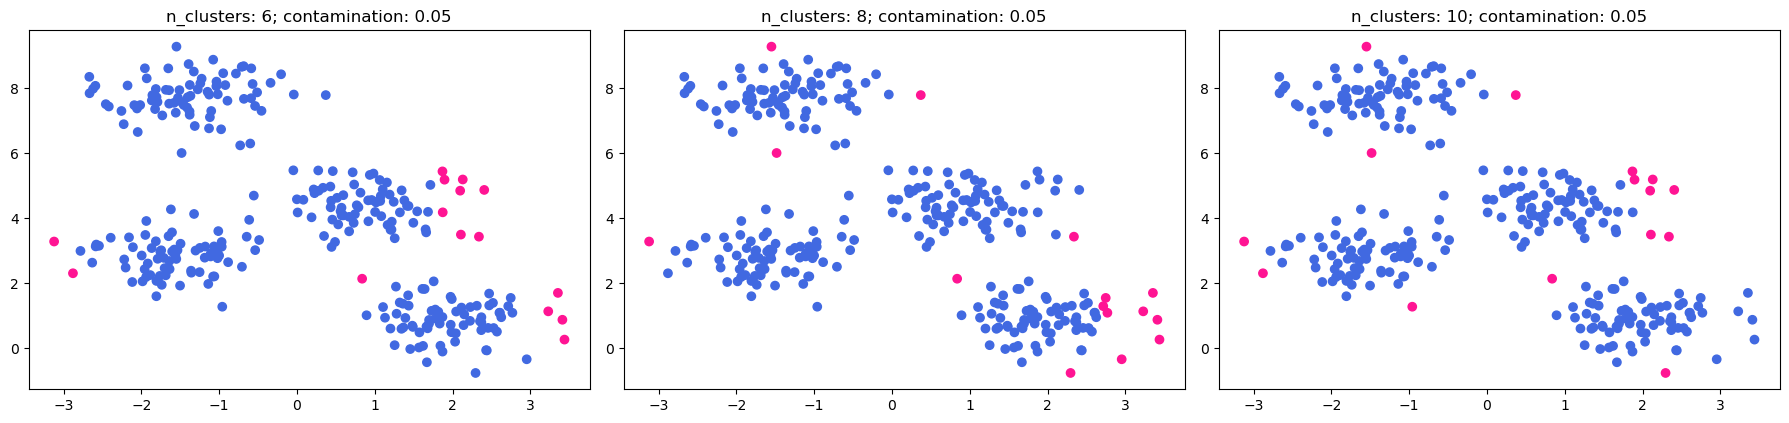

In [63]:
fig, axes = plt.subplots(5, 3, figsize=(18, 20))
for i, y_pred in enumerate([predictions[0], predictions[1], predictions[5]]):
    row, col = divmod(i, 3)
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    ax = axes[row, col]
    
    ax.scatter(X[:, 0], X[:, 1], c=vectorizer((y_pred[2] + 1) // 2))
    ax.set_title('n_clusters: ' + str(y_pred[0]) + '; contamination: ' + str(y_pred[1])[:4])

# hide extra plots
for i in range(3, 5 * 3):
    row, col = divmod(i, 3)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

Next, let's observe how contamination works

We pick out all plot for n_clusters = 10

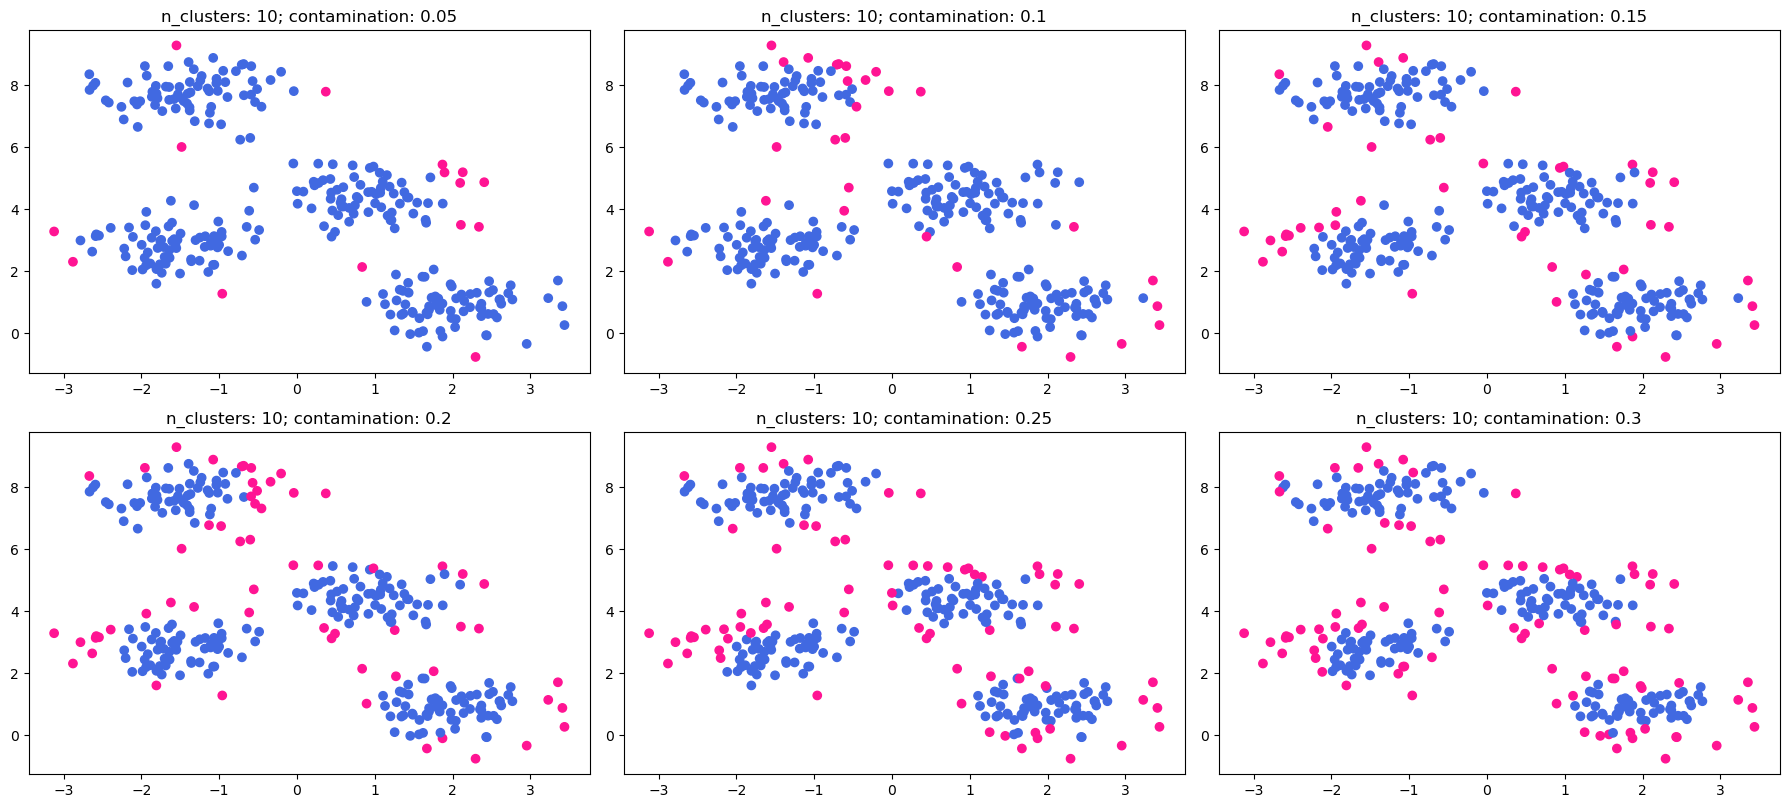

In [64]:
fig, axes = plt.subplots(5, 3, figsize=(18, 20))
for i, y_pred in enumerate(predictions[5:]):
    row, col = divmod(i, 3)
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    ax = axes[row, col]
    
    ax.scatter(X[:, 0], X[:, 1], c=vectorizer((y_pred[2] + 1) // 2))
    ax.set_title('n_clusters: ' + str(y_pred[0]) + '; contamination: ' + str(y_pred[1])[:4])

# hide extra plots
for i in range(len(predictions[5:]), 5 * 3):
    row, col = divmod(i, 3)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

### Compare - alpha

### Compare - beta

### Compare - use_weights

## Timeseries data
And now, we are finally trying to use CBLOF on timeseries data. Again, let's first try it on synthetic data.

### Noisy Dataset
Let's use a noisy signal with outliers

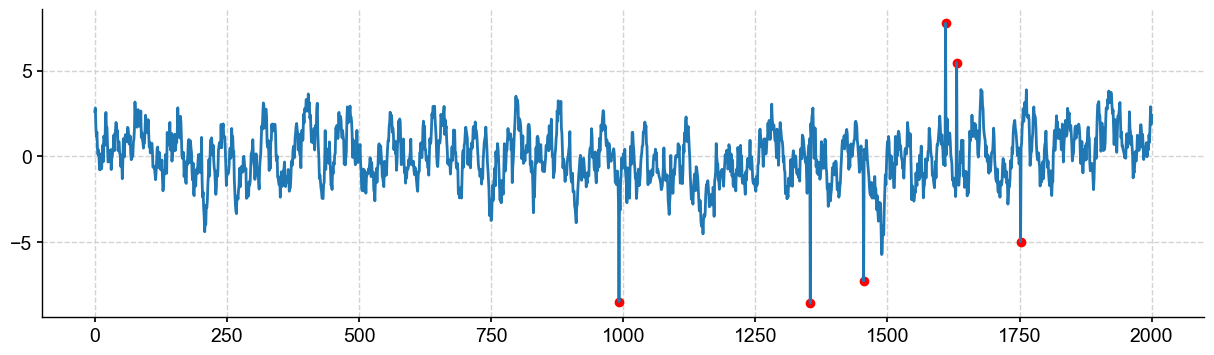

In [67]:
# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add colored noise
t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)

noisy_sig = signal + (v-np.mean(v))/np.std(v)

outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))

# set the outliers
nbr_out=6 #just add 6 random outliers
index = np.random.randint(0,len(noisy_sig),nbr_out) #Index on the time series
out_index = np.random.randint(0,len(outlier_values),nbr_out)
val_out=outlier_values[out_index]
time_out = time[index]

signal_out = np.copy(noisy_sig)
for idx,item in enumerate(index):
    signal_out[item] = val_out[idx]

fig=plt.figure(figsize=(15,4))
plt.plot(time,signal_out)
plt.scatter(time_out,outlier_values[out_index],color='r')

In [68]:
np.sort(index)

array([ 992, 1354, 1455, 1610, 1631, 1752])

#### Train model

In [92]:
# list of parameters being tested
cluster_list = np.arange(2,11,1)
contam_list = np.arange(0.005, 0.035, 0.005)

In [93]:
%%time
# Train the model and record the results, labels_: 0 -> inliers and 1 -> outliers/anomalies
predictions = []
for c in cluster_list:
    for contam in contam_list:
        try:
            model = CBLOF(n_clusters=c, contamination=contam)
            model.fit(signal_out.reshape(-1,1))
            pred = model.labels_
            indices = np.where(pred==1)
            predictions.append([c, contam, indices])
        except:
            pass

CPU times: total: 40.8 s
Wall time: 18.5 s


#### Plot results

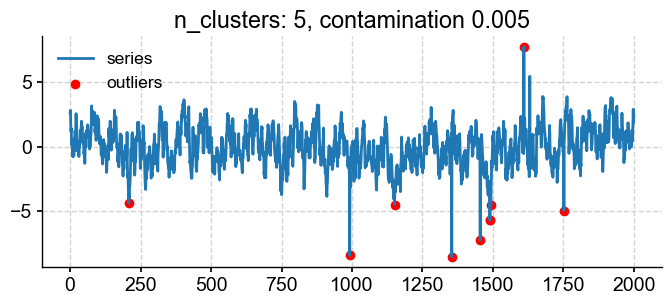

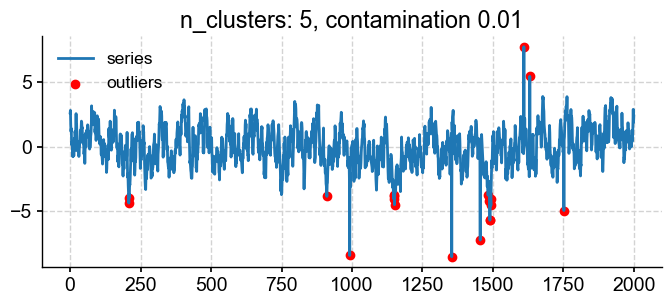

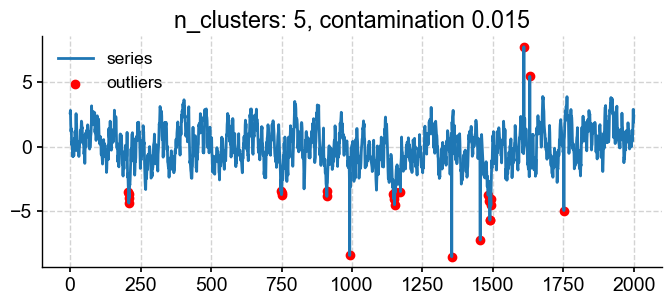

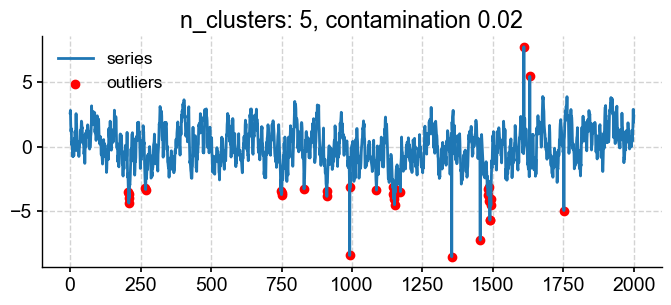

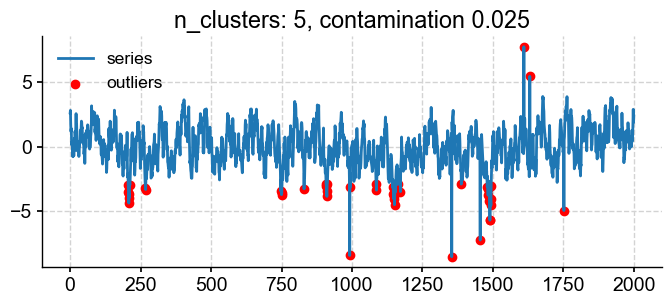

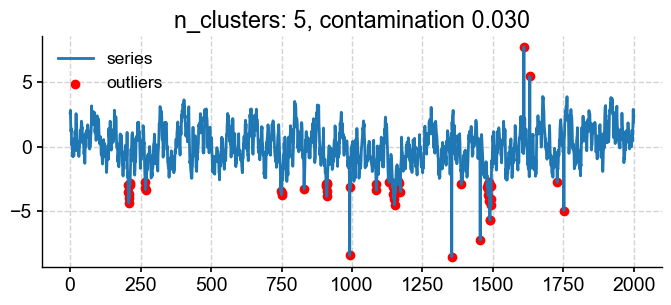

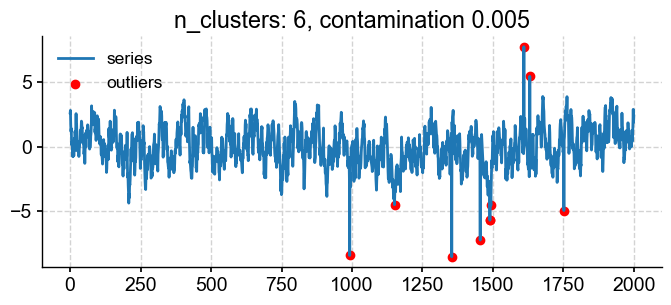

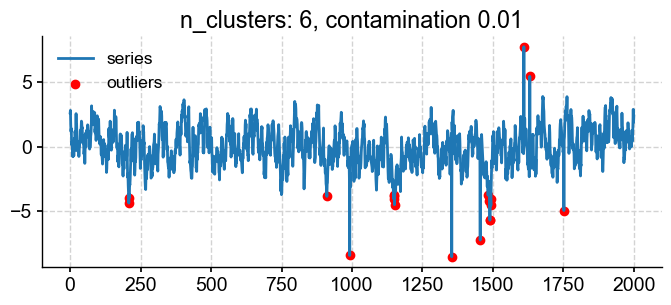

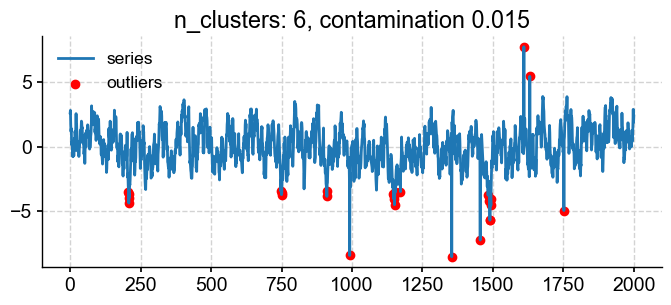

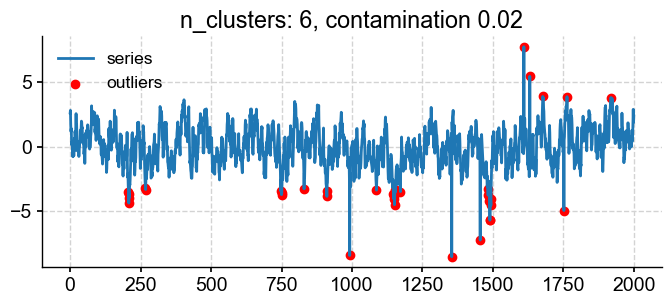

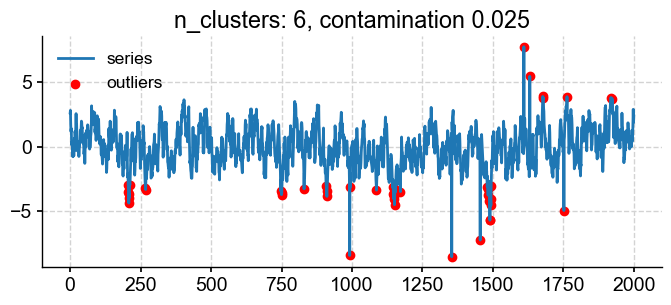

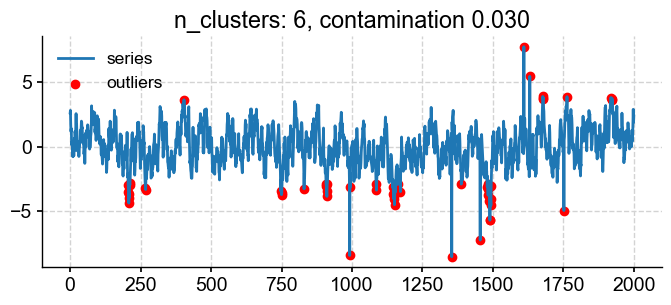

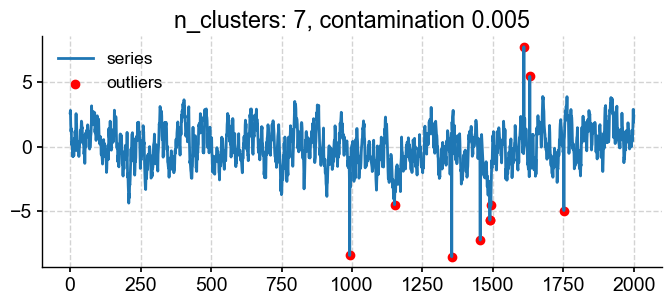

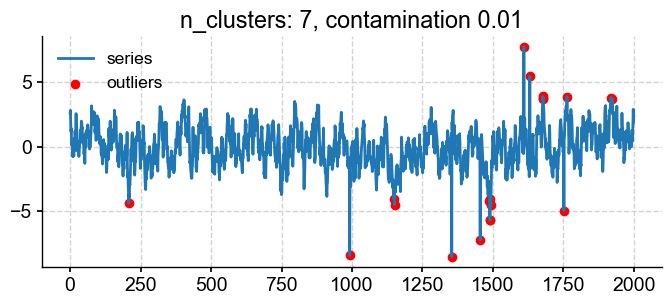

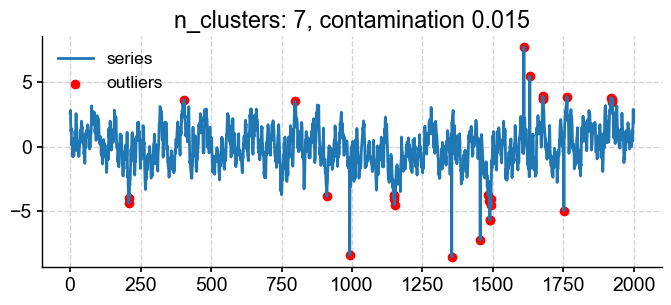

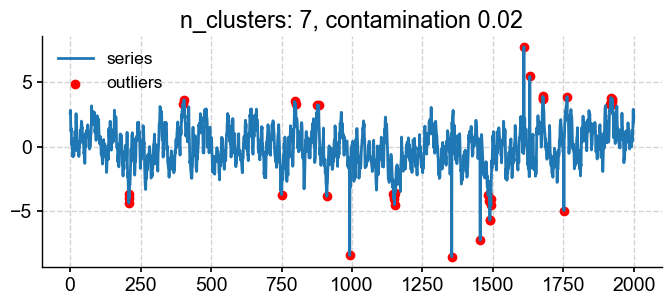

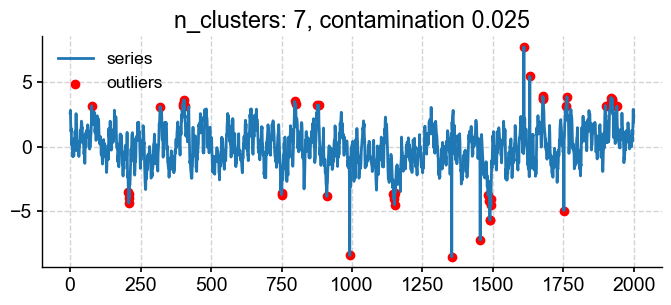

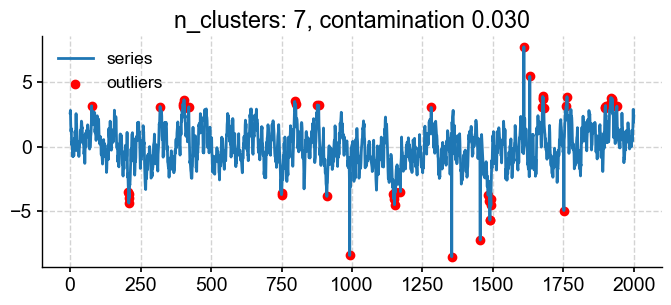

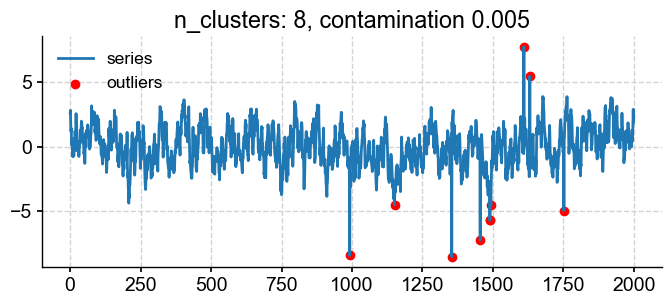

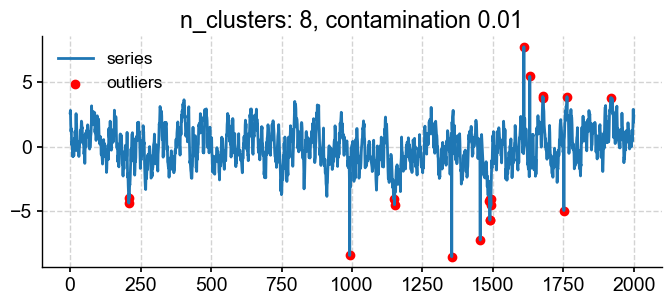

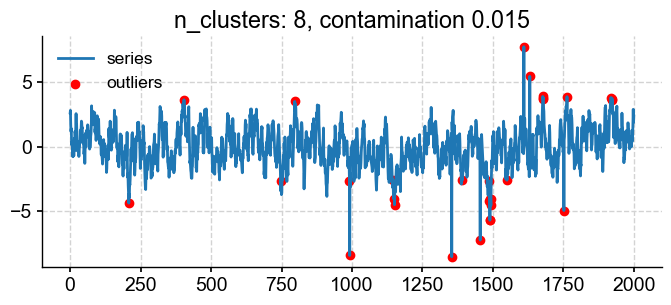

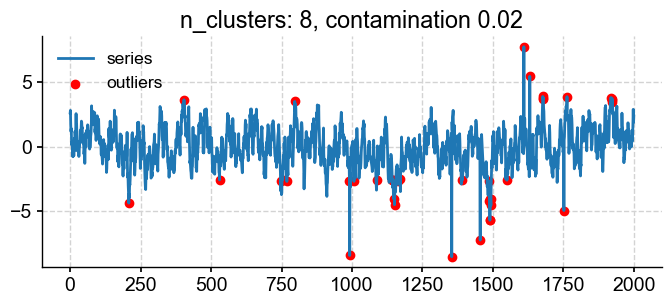

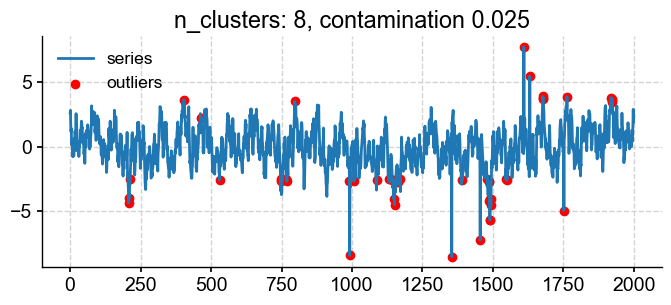

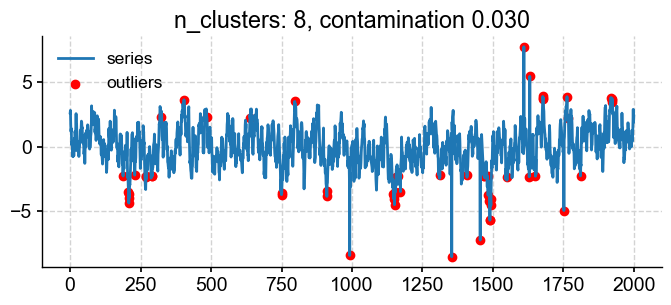

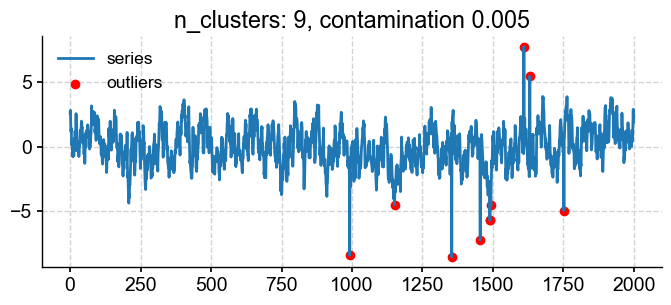

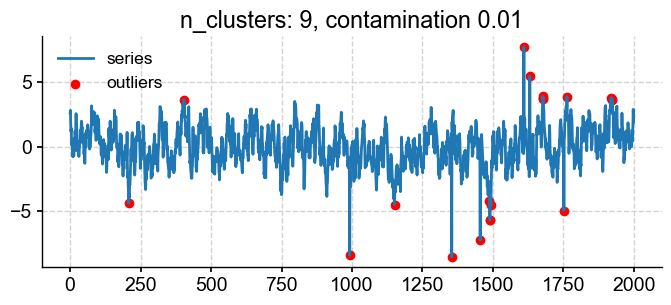

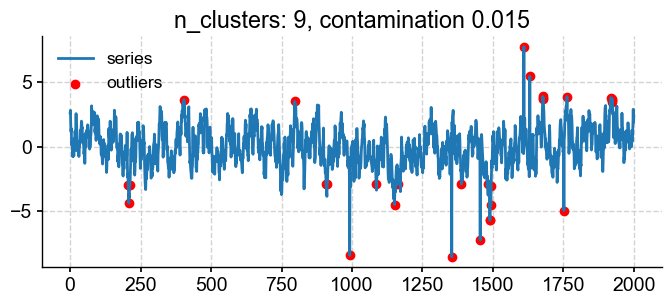

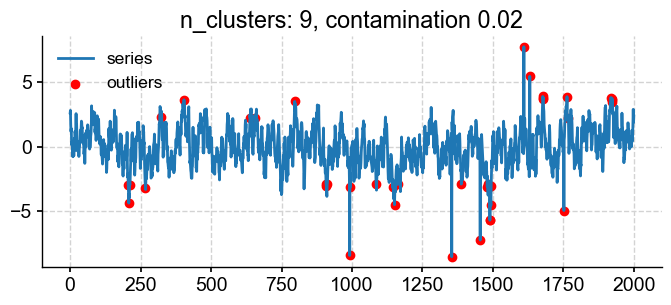

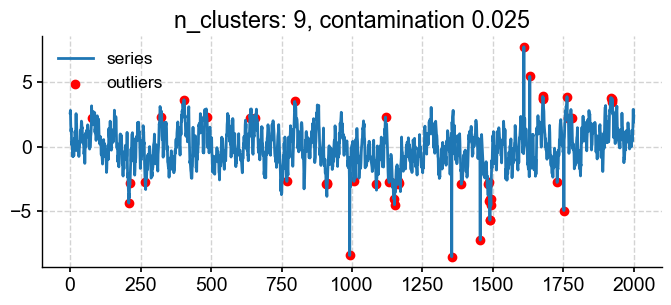

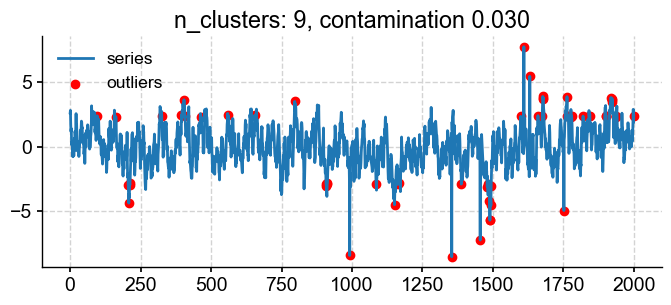

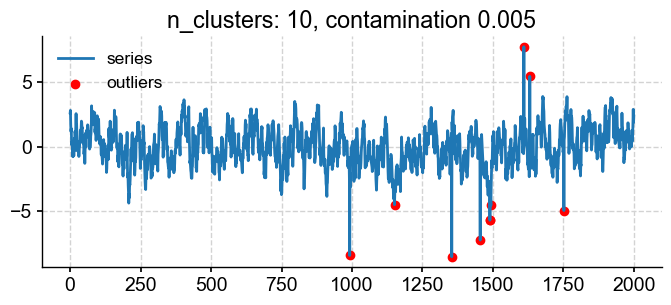

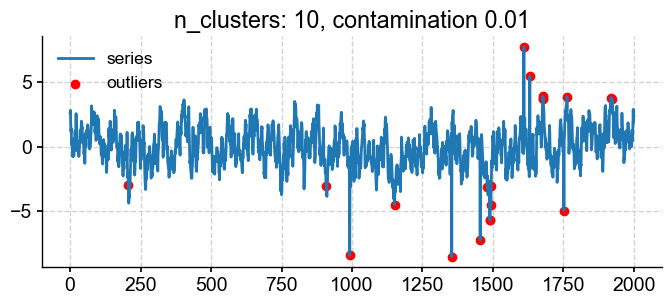

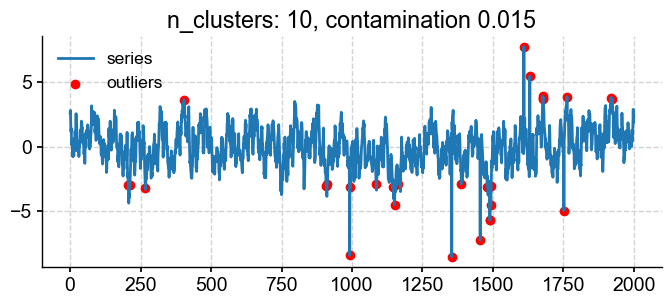

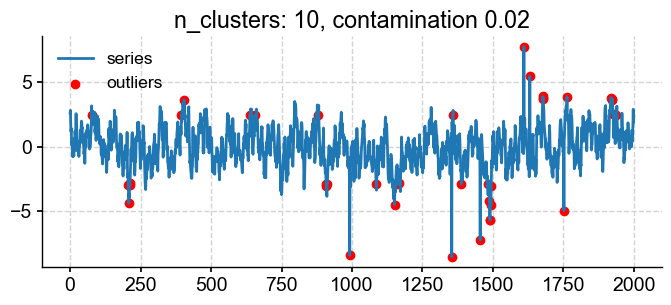

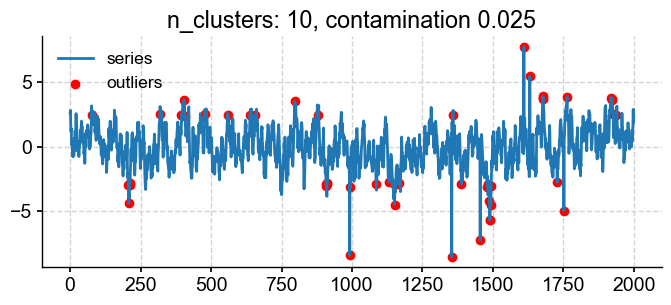

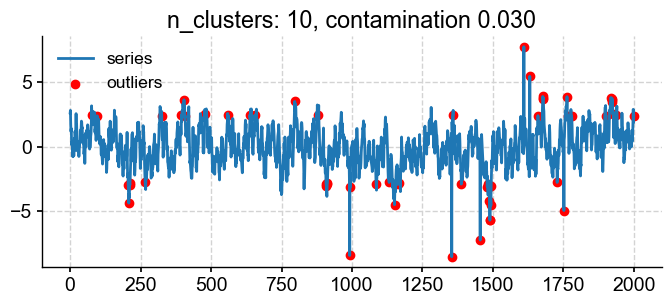

In [96]:
def plot_outliers(xs,ys,xs_out,ys_out,nb,contam):
    fig=plt.figure(figsize=(8,3))
    plt.plot(xs,ys,label='series')
    plt.scatter(xs_out,ys_out,color='r',label='outliers')
    plt.legend()
    plt.title('n_clusters: '+str(nb)+', contamination '+str(contam)[:5])
    plt.show()

for p in predictions:
    indices=p[2]
    xs_out=time[indices]
    ys_out=signal_out[indices]
    plot_outliers(time,signal_out,xs_out,ys_out,p[0], p[1])

Wow that's a lot of plot again, let's pick out some of them and look at how n_clusters affect the results.

We first choose two plots with n_clusters=5 and neighbor=10 with contamination=0.005 

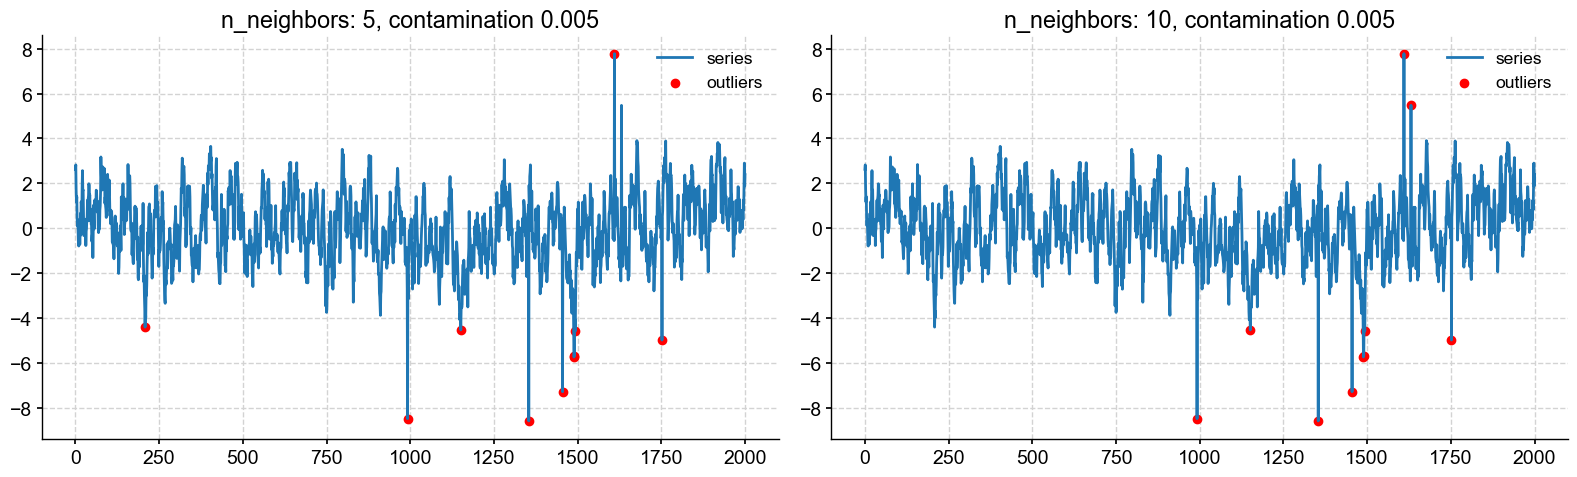

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for i, p in enumerate([predictions[0], predictions[-6]]):
    row, col = divmod(i, 2)
    #ax = axes[row, col]
    ax = axes[col]
    
    indices=p[2]
    xs_out=time[indices]
    ys_out=signal_out[indices]
    
    ax.plot(time,signal_out,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    ax.set_title('n_neighbors: '+str(p[0])+', contamination '+str(p[1])[:5])

plt.tight_layout()
plt.show()

Let's skip the comparison of contamination since it simply lowers the threshold and allow more points to be detected as outliers

See LOF NB for details: [LINK](LOF.ipynb)

## (WIP) Working with real paleoclimate series
Finally, we're trying the LOF method on real paleoclimate series

### MD98-2181
MD98-2181 SST over the Holocene from Khider et al. (low signal-to-noise ratio- outliers??)

In [ ]:
D=pyleo.Lipd('MD982181.Khider.2014.lpd')

In [ ]:
ts=D.to_LipdSeries(number=14)

In [ ]:
ts.plot()

In [ ]:
ts_detrended=ts.detrend(n=2)
ts_detrended.plot()

In [ ]:
ts_detrended.value = pyleo.utils.tsutils.standardize(ts_detrended.value)[0]
ts_detrended.value=np.array(ts_detrended.value)

#### Train model
Here we try out some parameter combinations of LOF

In [ ]:
# list of parameters being tested
max_sample = ts_detrended.value.size
nb_list = np.arange(max_sample//2,max_sample,(max_sample-max_sample//2)//5)
contam_list = np.arange(0.01, 0.06, 0.01)

# Train the model and record the results
predictions = []
for nb in nb_list:
    for contam in contam_list:
        model = LocalOutlierFactor(n_neighbors=nb, contamination=contam)
        pred = model.fit_predict(ts_detrended.value.reshape(-1,1))
        indices = np.where(pred==-1)
        predictions.append([nb, contam, indices])

#### Plot result

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
for i, p in enumerate(predictions[-5:]):
    row, col = divmod(i, 1)
    #ax = axes[row, col]
    ax = axes[row]
    
    indices=p[2]
    xs_out=ts_detrended.time[indices]
    ys_out=ts_detrended.value[indices]
    
    ax.plot(ts_detrended.time, ts_detrended.value,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    ax.set_title('n_neighbors: '+str(p[0])+', contamination '+str(p[1])[:5])

plt.tight_layout()
plt.show()

Let's also try with auto contamination

#### Train model
Here we try out some parameter combinations of LOF

In [ ]:
# Train the model and record the results
predictions = []
for nb in nb_list:
    model = LocalOutlierFactor(n_neighbors=nb)
    pred = model.fit_predict(ts_detrended.value.reshape(-1,1))
    indices = np.where(pred==-1)
    predictions.append([nb, indices])

#### Plot result

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
for i, p in enumerate(predictions[-5:]):
    row, col = divmod(i, 1)
    #ax = axes[row, col]
    ax = axes[row]
    
    indices=p[1]
    xs_out=ts_detrended.time[indices]
    ys_out=ts_detrended.value[indices]
    
    ax.plot(ts_detrended.time, ts_detrended.value,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    ax.set_title('n_neighbors: '+str(p[0])+', contamination: auto')

plt.tight_layout()
plt.show()

### GISP2 d18O
Deglacial Greenland d18O record, which contains a significant trend and the BA/YD event

In [ ]:
df = pd.read_csv('GISP2_Deglacial.csv')
df

In [ ]:
ts=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='d18O',
                time_unit='yr BP', value_unit='per mil')

In [ ]:
ts.plot()

In [ ]:
ts_detrended = ts.detrend()
fig,ax = ts_detrended.plot()

In [ ]:
ts_detrended.value = pyleo.utils.tsutils.standardize(ts_detrended.value)[0]
ts_detrended.value=np.array(ts_detrended.value)

#### Train model
Here we try out some parameter combinations of KNN

In [ ]:
# list of parameters being tested
max_sample = ts_detrended.value.size
nb_list = np.arange(max_sample//2,max_sample,(max_sample-max_sample//2)//5)
contam_list = np.arange(0.01, 0.050001, 0.01)

# Train the model and record the results
predictions = []
for nb in nb_list:
    for contam in contam_list:
        model = LocalOutlierFactor(n_neighbors=nb, contamination=contam)
        pred = model.fit_predict(ts_detrended.value.reshape(-1,1))
        indices = np.where(pred==-1)
        predictions.append([nb, contam, indices])

#### Plot result

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
for i, p in enumerate(predictions[-10:]):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    #ax = axes[row]
    
    indices=p[2]
    xs_out=ts_detrended.time[indices]
    ys_out=ts_detrended.value[indices]
    
    ax.plot(ts_detrended.time, ts_detrended.value,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    ax.set_title('n_neighbors: '+str(p[0])+', contamination '+str(p[1])[:5])

plt.tight_layout()
plt.show()

Let's also try with auto contamination

#### Train model
Here we try out some parameter combinations of LOF

In [ ]:
# Train the model and record the results
predictions = []
for nb in nb_list:
    model = LocalOutlierFactor(n_neighbors=nb)
    pred = model.fit_predict(ts_detrended.value.reshape(-1,1))
    indices = np.where(pred==-1)
    predictions.append([nb, indices])

#### Plot result

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for i, p in enumerate(predictions[-10:]):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    #ax = axes[row]
    
    indices=p[1]
    xs_out=ts_detrended.time[indices]
    ys_out=ts_detrended.value[indices]
    
    ax.plot(ts_detrended.time, ts_detrended.value,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    ax.set_title('n_neighbors: '+str(p[0])+', contamination: auto')

plt.tight_layout()
plt.show()

### LR04
The LR04 record, which is not noisy but contains large climate shifts

In [ ]:
df = pd.read_csv('LR04.csv',skiprows=4)
df

In [ ]:
ts=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='benthic d18O',
                time_unit='ks', value_unit='per mil')

In [ ]:
fig,ax = ts.plot()
ax.invert_yaxis()

In [ ]:
ts_detrended = ts.detrend()
fig,ax = ts_detrended.plot()
ax.invert_yaxis()

In [ ]:
ts_detrended.value = pyleo.utils.tsutils.standardize(ts_detrended.value)[0]
ts_detrended.value=np.array(ts_detrended.value)

#### Train model
Here we try out some parameter combinations of LOF

In [ ]:
# list of parameters being tested
max_sample = ts_detrended.value.size
nb_list = np.arange(max_sample//2,max_sample,(max_sample-max_sample//2)//5)
contam_list = np.arange(0.005, 0.010001, 0.001)

# Train the model and record the results
predictions = []
for nb in nb_list:
    for contam in contam_list:
        model = LocalOutlierFactor(n_neighbors=nb, contamination=contam)
        pred = model.fit_predict(ts_detrended.value.reshape(-1,1))
        indices = np.where(pred==-1)
        predictions.append([nb, contam, indices])

#### Plot result

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
for i, p in enumerate(predictions[-10:]):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    #ax = axes[row]
    
    indices=p[2]
    xs_out=ts_detrended.time[indices]
    ys_out=ts_detrended.value[indices]
    
    ax.plot(ts_detrended.time, ts_detrended.value,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    ax.set_title('n_neighbors: '+str(p[0])+', contamination '+str(p[1])[:5])

plt.tight_layout()
plt.show()

Let's also try with auto contamination

#### Train model
Here we try out some parameter combinations of LOF

In [ ]:
# Train the model and record the results
predictions = []
for nb in nb_list:
    model = LocalOutlierFactor(n_neighbors=nb)
    pred = model.fit_predict(ts_detrended.value.reshape(-1,1))
    indices = np.where(pred==-1)
    predictions.append([nb, indices])

#### Plot result

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
for i, p in enumerate(predictions[-5:]):
    row, col = divmod(i, 1)
    #ax = axes[row, col]
    ax = axes[row]
    
    indices=p[1]
    xs_out=ts_detrended.time[indices]
    ys_out=ts_detrended.value[indices]
    
    ax.plot(ts_detrended.time, ts_detrended.value,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    ax.set_title('n_neighbors: '+str(p[0])+', contamination: auto')

plt.tight_layout()
plt.show()

### (WIP) Silhouette Score method

Next, we're going to try auto-tuning on LOF using on simple blobs. There are two main parameters for [LOF](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html): 
1. n_neighbors: Number of neighbors to use by default for kneighbors queries.
2. contamination: The amount of contamination of the data set, i.e. the proportion of outliers in the data set. When fitting this is used to define the threshold on the scores of the samples.

Let's look at the impact of n_neighbors and contamination using Silhouette Score method:

- Run values of n_neighbors from 2 to 10
- Run values of contamination from (0, 0.5] with a 0.05 increase

Ref: 
- [Automatic Hyperparameter Tuning Method  for Local Outlier Factor, with Applications to Anomaly Detection](https://support.sas.com/content/dam/SAS/support/en/technical-papers/automatic-hyperparameter-tuning-method-for-local-outlier-factor-with-applications-to-anomaly-detection.pdf)


#### Generate nicely defined clusters

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

In [ ]:
import matplotlib.colors as mcolors

color_cluster = list(mcolors.CSS4_COLORS.keys())
color_cluster.remove('red')
colors=['red']+color_cluster


nb_list = np.arange(2,11,1)
contam_list = np.arange(0.05, 0.55, 0.05)

nbr_clusters=[]
sil_score =[]
nb_matrix=[]
contam_matrix=[]

for nb in nb_list:
    for contam in contam_list:
        nb_matrix.append(nb)
        contam_matrix.append(contam)
        m = LocalOutlierFactor(n_neighbors=nb, contamination=contam, novelty=False)
        m.fit(X)
        nbr_clusters.append(len(np.unique(m.labels_)))
        try:
            sil_score.append(silhouette_score(X, m.labels_))
        except:
            sil_score.append(np.nan)

res = pd.DataFrame({'n_neighbors':nb_matrix,'contamination':contam_matrix,'number of clusters':nbr_clusters,'silhouette score':sil_score})
res

In [ ]:
# import matplotlib.colors as mcolors

# color_cluster = list(mcolors.CSS4_COLORS.keys())
# color_cluster.remove('red')
# colors=['red']+color_cluster

# nb_list = np.arange(2,11,1)
# contam_list = np.arange(0.05, 0.55, 0.05)

# nb_matrix=[]
# contam_matrix=[]

# real_nb_matrix=[] # actual number of neighbors used
# eff_metric_matrix=[] # the effective metric used for the distance computation.

# for nb in nb_list:
#     for contam in contam_list:
#         nb_matrix.append(nb)
#         contam_matrix.append(contam)
#         m = LocalOutlierFactor(n_neighbors=nb, contamination=contam, novelty=False)
#         m.fit(X)
#         real_nb_matrix.append(m.n_neighbors_)
#         eff_metric_matrix.append(m.effective_metric_)
#         try:
#             sil_score.append(silhouette_score(X, m.labels_))
#         except:
#             sil_score.append(np.nan)

# res = pd.DataFrame({'n_neighbors':nb_matrix,'contamination':contam_matrix,'actual neighbor':real_nb_matrix, 'effective metric':eff_metric_matrix, 
#                     'silhouette score':sil_score})
# res